# Introduction

Now that you have a feel for how to optimize your machine learning pipeline, let's practice with a real world dataset.
You'll use cross validation and a hyperparameter grid search to optimize your machine learning pipeline.

You will use the Titanic Survival Dataset to build a classification model to predict whether a passenger survived the sinking of the Titanic, based on attributes of each passenger in the data set.

You'll start with building a Random Forest Classifier, then modify your pipeline to use a Logistic Regression estimator instead. You'll evaluate and compare your results.

This lab will help prepare you for completing the Final Project.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import ssl
import certifi
import urllib.request

# Dataset

In [13]:
opener = urllib.request.build_opener(
    urllib.request.HTTPSHandler(context=ssl.create_default_context(cafile=certifi.where()))
)
urllib.request.install_opener(opener)

titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Data pre-processing

In [14]:
titanic.count()

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

Features to drop: `deck` has a lot of missing values, `age` has some missing values too. `embark` and `embark_town` are not relevant. `alive` is unclear.

Target: `survived`

In [16]:
features = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

In [21]:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

So about 38% of the passengers in the data set survived.  
Because of this slight imbalance, we should stratify the data when performing train/test split and for cross-validation.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Define preprocessing transformers for numerical and categorical features. Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [ ]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: ", numerical_features)
print(f"Categorical features: ", categorical_features)

Numerical features:  ['pclass', 'sibsp', 'parch', 'fare']
Categorical features:  ['sex', 'class', 'who']


Define separate preprocessing pipelines for both feature types

In [29]:
numerical_transformer = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Combine the transformers into a single column transformer

We'll use the sklearn "column transformer" estimator to separately transform the features, which will then concatenate the output as a single feature space, ready for input to a machine learning estimator.

In [30]:
preprocessor = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ]
)

# Model pipeling with Random Forest

In [31]:
pipeline = Pipeline(steps = [
  ('preprocessor', preprocessor),  
  ('classifier', RandomForestClassifier(random_state=42))
])

Define a parameter grid

We'll use the grid in a cross validation search to optimize the model

In [32]:
param_grid = {
  'classifier__n_estimators': [50, 100],
  'classifier__max_depth': [None, 10, 20],
  'classifier__min_samples_split': [2, 5]
}

Perform grid search cross-validation and fit the best model to the training data

In [38]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True)

# Train the pipeline
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cross_validation, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


Get the model predictions from the grid search estimator on the unseen data and print a classification report

In [39]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       110
           1       0.70      0.71      0.71        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



Class 0 (did not survive):
- Precision = 0.82 → Of all passengers predicted as “did not survive,” 82% were correct. (Few false alarms here.)
- Recall = 0.81 → Of all passengers who really didn’t survive, the model caught 81% of them.
- F1 = 0.81 → Balanced score combining precision & recall.
- Support = 110 → There were 110 actual “did not survive” cases in your test set.

Class 1 (survived):
- Precision = 0.70 → Of all predicted as “survived,” 70% were correct. (More false positives here compared to class 0.)
- Recall = 0.71 → Of all actual survivors, the model identified 71%.
- F1 = 0.71 → Decent balance, but lower than class 0.
- Support = 69 → There were 69 actual survivors in your test set.


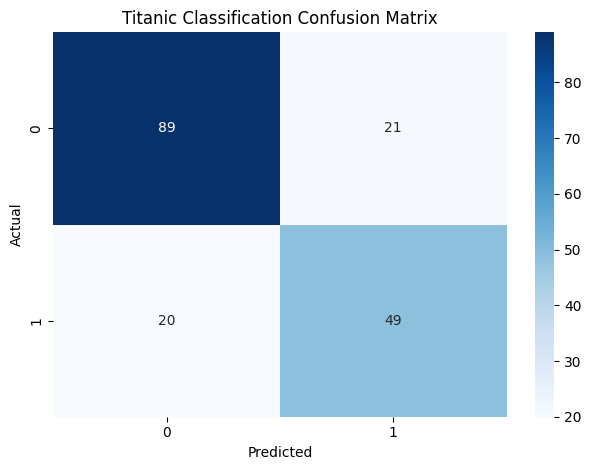

In [40]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## Feature importance

First, to obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their one-hot encoded input features that were transformed from the original categorical features.

We don't need to trace back through the pipeline for the numerical features, because we didn't transfrom them into new ones in any way.
Remember, we went from categorical features to one-hot encoded features, using the 'cat' column transformer.

Here's how you trace back through the trained model to access the one-hot encoded feature names:

In [48]:
onehot_feature_names = model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
print(onehot_feature_names)

['sex_female' 'sex_male' 'class_First' 'class_Second' 'class_Third'
 'who_child' 'who_man' 'who_woman']


In [49]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(onehot_feature_names)
print(feature_names)

['pclass', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'class_First', 'class_Second', 'class_Third', 'who_child', 'who_man', 'who_woman']


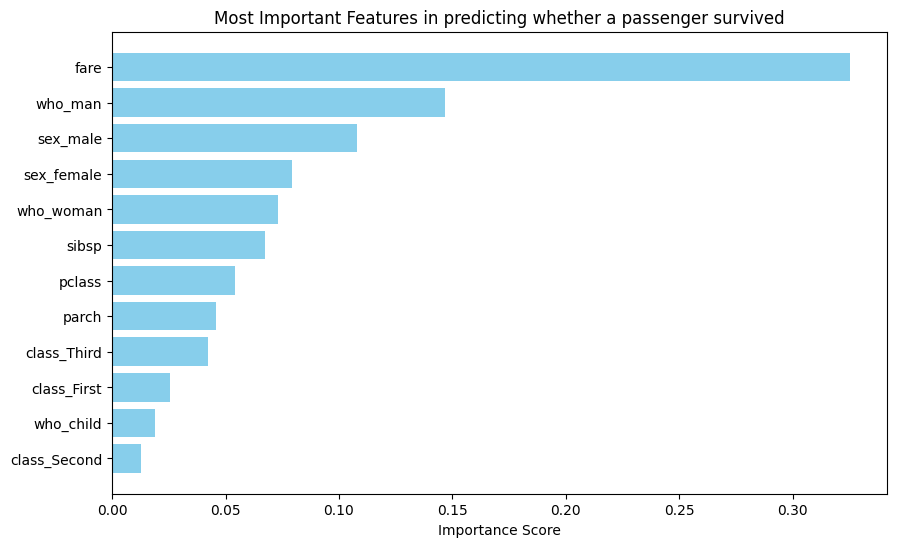


Test set accuracy:  77.09%


In [55]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                            }).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score: .2%}")


The test set accuracy is somewhat satisfactory. However,regarding the feature importances, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, no doubt there is significant information shared by the variables `age`, `sex_male`, and `who_man`.

# Model pipeling with Linear Regression

In [56]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))

model.estimator = pipeline

param_grid = {
  'classifier__solver': ['liblinear'],
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']
}

model.param_grid = param_grid

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



All of the scores are slightly better for logistic regression than for random forest classification, although the differences are insignificant.

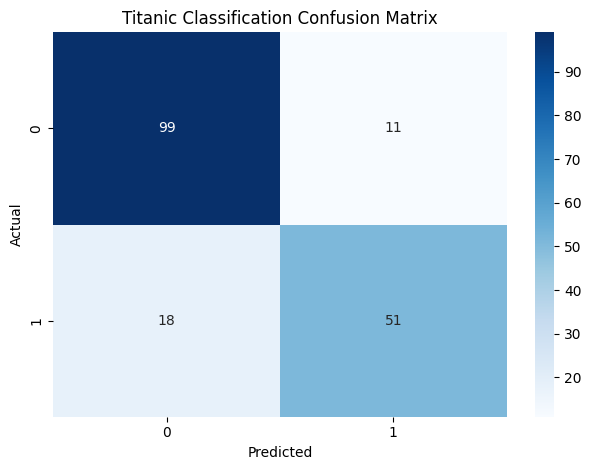

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [62]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

feature_names = numerical_feature_names + list(categorical_feature_names)

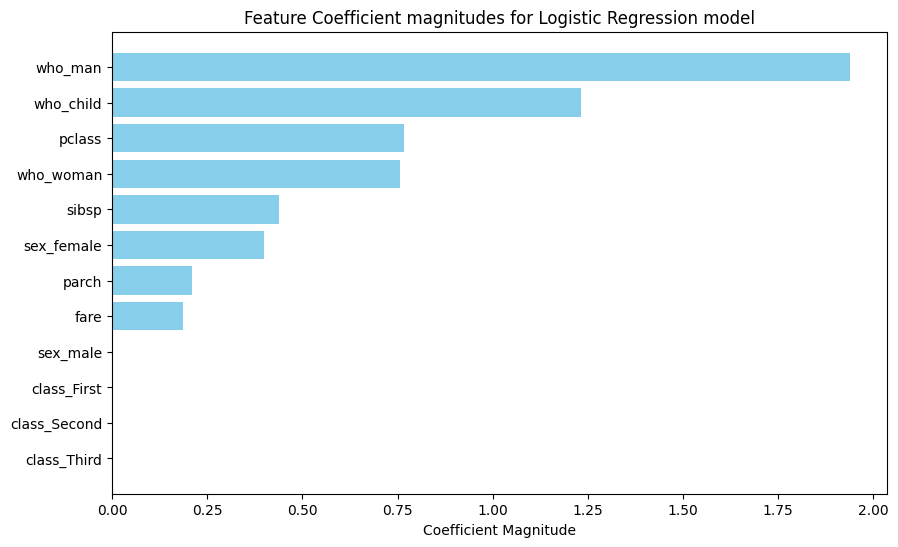


Test set accuracy:  83.80%


In [66]:
importance_df = pd.DataFrame({
  'Feature': feature_names,
  'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score: .2%}")
